In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torch.nn import functional as F
import pandas as pd

seed = 95

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [3]:
def generate_federated_datasets(dataset, num_clients, alpha, num_samples_per_client):
    """
    Generate federated datasets using Dirichlet distribution.
    
    :param dataset: PyTorch dataset (e.g., MNIST)
    :param num_clients: Number of clients
    :param alpha: Concentration parameter for Dirichlet distribution
    :param num_samples_per_client: List of number of samples per client
    :return: List of DataLoaders for each client
    """
    assert len(num_samples_per_client) == num_clients, "Length of num_samples_per_client must match num_clients"
    
    num_classes = len(np.unique(dataset.targets))
    
    # Generate Dirichlet distribution for label distributions for each client
    label_distributions = np.random.dirichlet([alpha] * num_clients, num_classes)
    
    # Get indices of each class in the dataset
    class_indices = [np.where(np.array(dataset.targets) == i)[0] for i in range(num_classes)]
    
    # Allocate instances to each client based on the generated label distributions
    client_indices = [[] for _ in range(num_clients)]
    for c in range(num_classes):
        np.random.shuffle(class_indices[c])
        proportions = np.cumsum(label_distributions[c])
        proportions = np.insert(proportions, 0, 0)
        class_splits = [int(p * len(class_indices[c])) for p in proportions]
        
        for i in range(num_clients):
            client_indices[i].extend(class_indices[c][class_splits[i]:class_splits[i+1]])
    
    # Create DataLoader for each client
    client_loaders = []
    client_datasets = []
    for i, indices in enumerate(client_indices):
        if num_samples_per_client[i] < len(indices):
            indices = np.random.choice(indices, num_samples_per_client[i], replace=False)
        client_dataset = Subset(dataset, indices)
        client_loaders.append(DataLoader(client_dataset, batch_size=32, shuffle=True))
        client_datasets.append(client_dataset)
    
    return client_datasets, client_loaders

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='../../data', train=True, download=True, transform=transform)

num_clients = 10
alpha = 0.5
#n_samples_per_client = [1000, 200, 300, 900, 1100]
#n_samples_per_client = np.random.uniform(0,1,num_clients)
# Generate Dirichlet distribution for data size distributions for each client
n_samples_per_client = np.random.dirichlet([alpha] * num_clients, 1)[0]
n_samples_per_client = np.round(n_samples_per_client/np.sum(n_samples_per_client)*len(dataset))
n_samples_per_client = n_samples_per_client.astype(int)
client_datasets, client_loaders = generate_federated_datasets(dataset, num_clients, alpha, n_samples_per_client)

# Access each client's DataLoader
for i, loader in enumerate(client_loaders):
    print(f"Client {i+1} has {len(loader.dataset)} samples")

Client 1 has 626 samples
Client 2 has 5838 samples
Client 3 has 3413 samples
Client 4 has 2800 samples
Client 5 has 5413 samples
Client 6 has 3093 samples
Client 7 has 2917 samples
Client 8 has 1416 samples
Client 9 has 785 samples
Client 10 has 6133 samples


In [4]:
#plot a heatmap: X-axis is client number, Y-axis is label number, and the value in each cell is the number of samples in that client with that label.
def plot_label_distributions(client_loaders):
    num_clients = len(client_loaders)
    num_classes = len(np.unique(client_loaders[0].dataset.dataset.targets))
    label_counts = np.zeros((num_clients, num_classes))
    
    for i, loader in enumerate(client_loaders):
        for _, labels in loader:
            for c in labels:
                label_counts[i][c] += 1
    
    #plt.figure(figsize=(5, 8))
    sns.heatmap(label_counts.T, annot=True, fmt=".1f", cmap="Blues", cbar=False)
    plt.xlabel("Client ID")
    plt.ylabel("Label")
    plt.title("Label distributions for each client")
    plt.show()

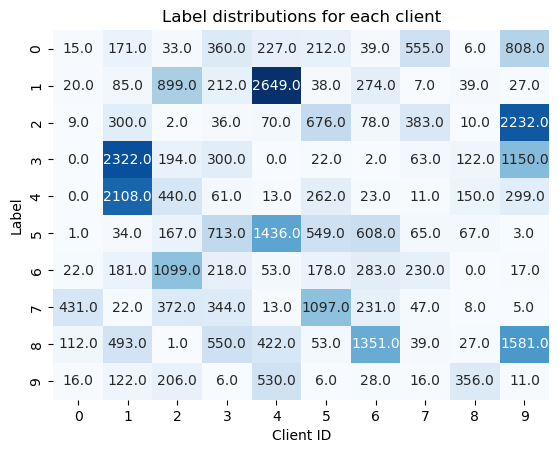

In [5]:
plot_label_distributions(client_loaders)

In [29]:
class FederatedClient():
    def __init__(self, model, criterion, train_loader, device, val_loader=None):
        self.model = model
        #self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        
    def train(self, num_epochs, learning_rate, weight_decay, fed_alg, mu=0):
        optimizer = optim.SGD(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.model.to(self.device)
        self.model.train()
        global_model = copy.deepcopy(self.model)
        train_loss = []
        train_acc = []
        for epoch in range(num_epochs):
            epoch_loss = 0
            epoch_acc = 0
            loss1_sum = 0
            loss2_sum = 0
            for i, (x, y) in enumerate(self.train_loader):
                x = x.to(self.device)
                y = y.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(x)
                if(fed_alg=='fedavg'):
                    loss = self.criterion(outputs, y)
                elif(fed_alg=='fedprox'):
                    proximal_term = 0.0
                    for param, global_param in zip(self.model.parameters(), global_model.parameters()):
                        proximal_term += torch.norm(param - global_param, p=2)
                    loss1 = self.criterion(outputs, y) 
                    loss2 = mu/2 * proximal_term
                    loss = loss1 + loss2
                loss.backward()

                # Clip gradients
                #torch.nn.utils.clip_grad_norm_(self.model.parameters(), clip_value)

                optimizer.step()
                epoch_loss += loss.item()
                epoch_acc += (outputs.argmax(1) == y).sum().item()

            train_loss.append(epoch_loss / len(self.train_loader))
            train_acc.append(epoch_acc / len(self.train_loader.dataset))
        
        return self.model, train_loss, train_acc
    
    def test(self,test_loader):
        self.model.to(self.device)
        self.model.eval()
        test_loss = 0
        test_acc = 0
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(self.device)
                y = y.to(self.device)
                outputs = self.model(x)
                loss = self.criterion(outputs, y)
                test_loss += loss.item()
                test_acc += (outputs.argmax(1) == y).sum().item()
        
        return test_loss / len(test_loader), test_acc / len(test_loader.dataset)
    
    def get_model(self):
        return self.model

def FedAvg(w,alpha):
    #alpha = alpha/np.sum(alpha) #normalize alpha
    w_avg = copy.deepcopy(w[0])
    n_clients = len(w)
    
    for l in w_avg.keys():
        w_avg[l] = w_avg[l] - w_avg[l]

    for l, layer in enumerate(w_avg.keys()): #for each layer
        w_kl = []
        for k in range(0,n_clients): #for each client
            w_avg[layer] += alpha[k]*w[k][layer]
    return w_avg
def softmax(x,tau):
    #x is a vector, tau is the temperature. large tau -> uniform distribution, small tau -> argmax
    return torch.exp(x/tau)/torch.sum(torch.exp(x/tau),dim=0)

def optimize_alpha(target_labels, source_labels, alpha, dataset_sizes, n_epochs, eta, mu):
    #given a vector T(y) (target labels) and S(y) (source labels), optimize alpha with SGD
    #initialize alpha
    dataset_sizes = torch.tensor(dataset_sizes)
    alpha = torch.tensor(alpha, requires_grad=True)
    optimizer = optim.SGD([alpha], lr=eta)
    for i in range(n_epochs):
        #soft_alpha = softmax(alpha, 0.1)
        loss = torch.norm(target_labels - torch.matmul(source_labels,alpha),p=2)
        #loss2 = mu * torch.norm(alpha/dataset_sizes,p=2)
        #loss = loss1 + loss2
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        #torch.nn.utils.clip_grad_norm_([alpha], 0.5)

        optimizer.step()
        
        print(alpha.detach().numpy(), loss.item())
    return alpha

def train_fed(n_communication, num_local_epochs, clients_fed, lr, test_loader, wd=0.0, optimize_alpha_bool=False, target_labels=None, source_labels=None):
    n_clients = len(clients_fed)
    mean_loss_fed = []
    mean_acc_fed = []
    test_acc_fed = []
    dataset_sizes = [clients_fed[i].train_loader.dataset.__len__() for i in range(n_clients)]
    if(not optimize_alpha_bool):
        alpha = np.array(dataset_sizes)/np.sum(dataset_sizes)
        print(alpha)
    for k in range(n_communication):
        train_losses_fed = []
        train_accs_fed = []
        param = []
        for i in range(n_clients-1):
            client_model, train_loss_fed, train_acc_fed = clients_fed[i].train(num_local_epochs,lr,wd,'fedavg')
            param.append(copy.deepcopy(client_model.state_dict()))
            train_losses_fed.append(train_loss_fed[-1])
            train_accs_fed.append(train_acc_fed[-1])

        mean_loss_fed.append(np.mean(train_losses_fed))
        mean_acc_fed.append(np.mean(train_accs_fed))
        print(f'Round {k} - mean loss: {mean_loss_fed[-1]}, mean acc: {mean_acc_fed[-1]}')

        if(optimize_alpha_bool):
            print(f'Round {k}')
            #initialize alpha
            alpha = np.random.rand(n_clients)
            alpha = alpha/np.sum(alpha)
            alpha = optimize_alpha(target_labels, source_labels, alpha, dataset_sizes, 20, 0.1, 1.0)
            alpha = alpha.detach().numpy()
            alpha = alpha/np.sum(alpha)
        w_global_model_fedavg = FedAvg(param, alpha)
        for i in range(n_clients):
            clients_fed[i].model.load_state_dict(copy.deepcopy(w_global_model_fedavg))

        test_loss, test_acc = clients_fed[0].test(test_loader)
        test_acc_fed.append(test_acc)

    return clients_fed[0].model, mean_loss_fed, mean_acc_fed, test_acc_fed


In [30]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

class MLP_MNIST(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP_MNIST, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

In [31]:
def split_data(dataset,n_parts):
    #split dataset into equal parts uniformly
    dataset_length = len(dataset)
    splits = np.array_split(np.arange(dataset_length), n_parts)
    dataset_sizes = [len(split) for split in splits]
    client_datasets = torch.utils.data.random_split(dataset, lengths=dataset_sizes)
    return client_datasets

def get_label_distribution(dataset,n_labels):
    #get the distribution of labels in a dataset and return a vector with the fraction of samples for each label
    labels = []
    for data in dataset:
        labels.append(data[1])
    labels = np.array(labels)
    label_distribution = np.zeros(n_labels)
    for i in range(n_labels):
        label_distribution[i] = np.sum(labels==i)
    label_distribution = label_distribution/np.sum(label_distribution)
    return label_distribution

In [32]:
source_label_list = [get_label_distribution(client_datasets[i],n_labels=10) for i in range (len(client_datasets))]

In [33]:
source_labels = np.array([])
for s in source_label_list:
    #create matrix of all source label distributions:
    source_labels = np.append(source_labels,s)
source_labels = source_labels.reshape(len(client_datasets),10)
source_labels = torch.tensor(source_labels).T


In [34]:
torch.sum(source_labels[:,-1])

tensor(1., dtype=torch.float64)

In [35]:
source_labels[:,0:-1]

tensor([[2.3962e-02, 2.9291e-02, 9.6689e-03, 1.2857e-01, 4.1936e-02, 6.8542e-02,
         1.3370e-02, 3.9195e-01, 7.6433e-03],
        [3.1949e-02, 1.4560e-02, 2.6340e-01, 7.5714e-02, 4.8938e-01, 1.2286e-02,
         9.3932e-02, 4.9435e-03, 4.9682e-02],
        [1.4377e-02, 5.1387e-02, 5.8599e-04, 1.2857e-02, 1.2932e-02, 2.1856e-01,
         2.6740e-02, 2.7048e-01, 1.2739e-02],
        [0.0000e+00, 3.9774e-01, 5.6841e-02, 1.0714e-01, 0.0000e+00, 7.1128e-03,
         6.8564e-04, 4.4492e-02, 1.5541e-01],
        [0.0000e+00, 3.6108e-01, 1.2892e-01, 2.1786e-02, 2.4016e-03, 8.4707e-02,
         7.8848e-03, 7.7684e-03, 1.9108e-01],
        [1.5974e-03, 5.8239e-03, 4.8931e-02, 2.5464e-01, 2.6529e-01, 1.7750e-01,
         2.0843e-01, 4.5904e-02, 8.5350e-02],
        [3.5144e-02, 3.1004e-02, 3.2200e-01, 7.7857e-02, 9.7912e-03, 5.7549e-02,
         9.7017e-02, 1.6243e-01, 0.0000e+00],
        [6.8850e-01, 3.7684e-03, 1.0900e-01, 1.2286e-01, 2.4016e-03, 3.5467e-01,
         7.9191e-02, 3.3192e-0

In [36]:
alpha=torch.tensor(np.random.rand(9))
alpha = alpha/torch.sum(alpha)
torch.norm(source_labels[:,-1] - torch.matmul(source_labels[:,0:-1],alpha),p=2)

tensor(0.5196, dtype=torch.float64)

In [37]:
origin_model = MLP_MNIST(784, 64, 10)
print(origin_model)

MLP_MNIST(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (activation): ReLU()
)


In [38]:
n_communication = 30
num_local_epochs = 1

model_fed = copy.deepcopy(origin_model)
criterion = nn.CrossEntropyLoss()
n_clients = len(client_loaders)
print('Number of clients: ', n_clients)
val_loader = None
lr = 0.01
wd = 0.0
device = 'cuda:0'

Number of clients:  10


In [39]:
clients_fed = []
for i in range(n_clients-1):
    clients_fed.append(FederatedClient(copy.deepcopy(origin_model), criterion, client_loaders[i], device, val_loader))

print(len(clients_fed))

model_fedavg, train_loss_fedavg, train_acc_fedavg, test_acc_fedavg = train_fed(n_communication, num_local_epochs, clients_fed, lr, test_loader=client_loaders[-1], wd=0.0, optimize_alpha_bool=False, target_labels=None, source_labels=None)

9
[0.02380138 0.22196875 0.12976693 0.10645983 0.20580967 0.11760009
 0.11090833 0.05383826 0.02984677]
Round 0 - mean loss: 1.2472360796364896, mean acc: 0.6204425998068845
Round 1 - mean loss: 0.8411652129774712, mean acc: 0.7742484588711077
Round 2 - mean loss: 0.619361767162738, mean acc: 0.8406448240860167
Round 3 - mean loss: 0.5003505247116955, mean acc: 0.8730654511932079
Round 4 - mean loss: 0.4357009669453181, mean acc: 0.8905202426847091
Round 5 - mean loss: 0.3981327228420163, mean acc: 0.8930748856102142
Round 6 - mean loss: 0.369754665575288, mean acc: 0.9002766960512045
Round 7 - mean loss: 0.3515261632618357, mean acc: 0.9071595163554864
Round 8 - mean loss: 0.33878663150539023, mean acc: 0.9076866905194301
Round 9 - mean loss: 0.32900986313481906, mean acc: 0.9087318826331197
Round 10 - mean loss: 0.31970494773991825, mean acc: 0.9115926748063767
Round 11 - mean loss: 0.31265096059272546, mean acc: 0.9148315012266044
Round 12 - mean loss: 0.30621234169702594, mean acc:

In [40]:
clients_fed = []
for i in range(n_clients-1):
    clients_fed.append(FederatedClient(copy.deepcopy(origin_model), criterion, client_loaders[i], device, val_loader))
print(len(clients_fed))
model_fedalpha, train_loss_fedalpha, train_acc_fedalpha, test_acc_fedalpha = train_fed(n_communication, num_local_epochs, clients_fed, lr, test_loader=client_loaders[-1], wd=0.0, optimize_alpha_bool=True, target_labels=source_labels[:,-1], source_labels=source_labels[:,0:-1])


9
Round 0 - mean loss: 1.242379452914808, mean acc: 0.6219688696918284
Round 0
[0.00659239 0.15762639 0.19517124 0.06716446 0.0080243  0.17639257
 0.03663368 0.23030582 0.09734462] 0.40898299283999395
[-0.0042217   0.16506169  0.1746074   0.06735691 -0.00349869  0.17441411
  0.05004917  0.24368475  0.08955165] 0.3967989361586384
[-0.01383207  0.17266563  0.15482251  0.06782581 -0.01391724  0.17309296
  0.06395258  0.25698297  0.08236476] 0.3854857118829632
[-0.02242079  0.18034501  0.13573663  0.0684267  -0.02333944  0.17228832
  0.07816738  0.27009297  0.07571242] 0.37492434576948247
[-0.03014071  0.18802283  0.11728433  0.06903853 -0.0318582   0.17188298
  0.09254354  0.28292709  0.06953408] 0.36503667567335546
[-0.03711779  0.19563659  0.0994141   0.06956169 -0.03955225  0.17178118
  0.1069548   0.29541532  0.06377943] 0.3557712942134229
[-0.04345425  0.20313647  0.0820869   0.06991581 -0.04648777  0.17190611
  0.12129592  0.30750317  0.05840715] 0.3470931585275627
[-0.04923201  0.2

In [16]:
np.sum(np.array([ 0.08551682, -0.1886856 ,  0.47567357 , 0.30127594 ,-0.22296916 , 0.12180724, 0.18096235 , 0.17005322  ,0.18622196]))

1.1098563399999999

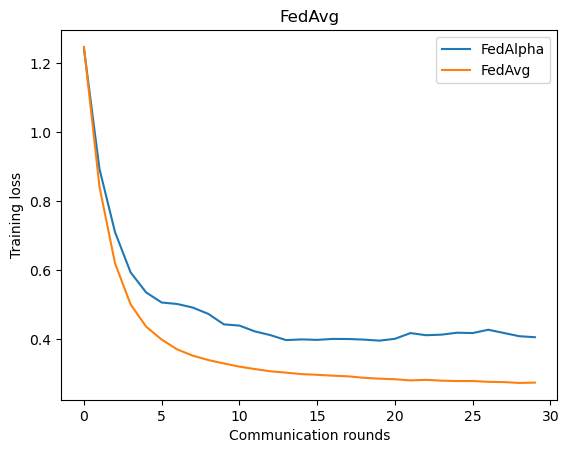

In [41]:
plt.plot(train_loss_fedalpha)
plt.plot(train_loss_fedavg)
plt.xlabel('Communication rounds')
plt.ylabel('Training loss')
plt.title('FedAvg')
plt.legend(['FedAlpha', 'FedAvg'])

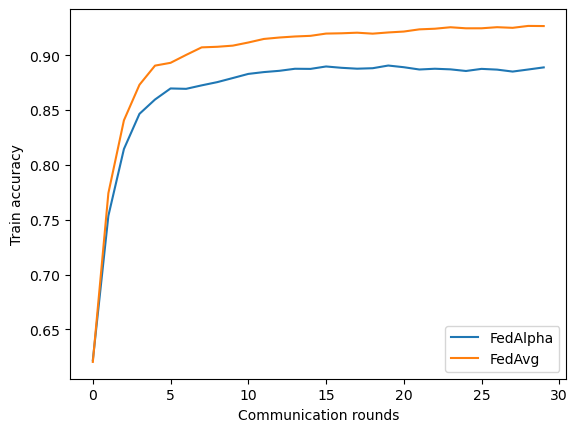

In [42]:
plt.plot(train_acc_fedalpha)
plt.plot(train_acc_fedavg)
plt.xlabel('Communication rounds')
plt.ylabel('Train accuracy')
plt.legend(['FedAlpha', 'FedAvg'])

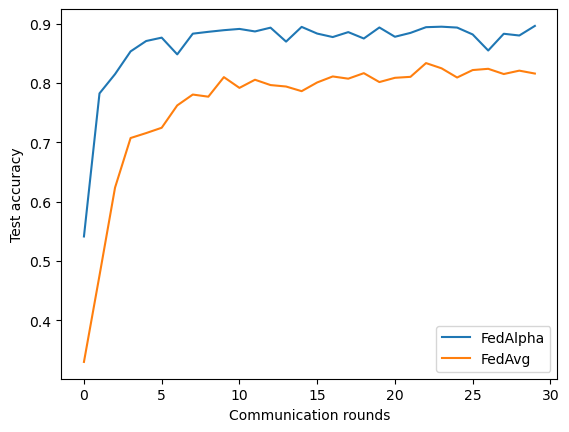

In [43]:
plt.plot(test_acc_fedalpha)
plt.plot(test_acc_fedavg)
plt.xlabel('Communication rounds')
plt.ylabel('Test accuracy')
plt.legend(['FedAlpha', 'FedAvg'])

In [33]:
df = pd.read_csv('/home/edvinli/Documents/Git/FedDG_Benchmark-1/fed_alpha_experiments/save/mnist/results', sep=';')
df

,n_rounds,num_clients,local_ep,bs,lr,seed,dirichlet_beta,dataset,test_acc_fedavg,test_acc_fedalpha
0,30,10,1,32,0.01,93,0.5,mnist,0.582946,0.757999
1,30,10,1,32,0.01,8875,0.5,mnist,0.802950,0.783481
2,30,10,1,32,0.01,4236,1.0,mnist,0.869366,0.904049
3,30,10,1,32,0.01,2183,5.0,mnist,0.868360,0.885029
4,30,10,1,32,0.01,5707,10.0,mnist,0.883084,0.872889
5,30,10,1,32,0.01,1381,0.5,mnist,0.870025,0.900756
6,30,10,1,32,0.01,1843,1.0,mnist,0.834146,0.741463
7,30,10,1,32,0.01,4500,5.0,mnist,0.878835,0.879799
8,30,10,1,32,0.01,5542,10.0,mnist,0.884534,0.889091
9,30,10,1,32,0.01,7867,0.5,mnist,0.785779,0.927985


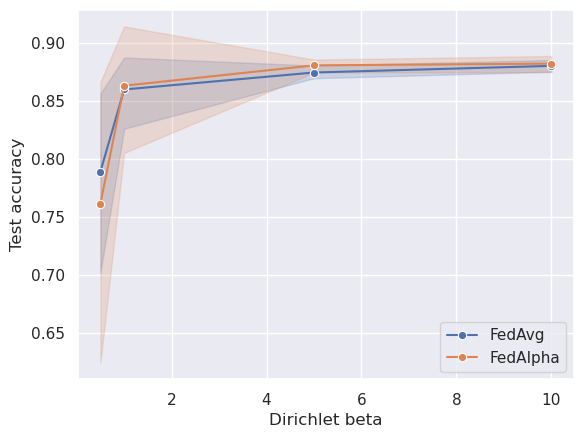

In [34]:
sns.set_theme()
sns.set_style("darkgrid")
sns.lineplot(data=df, x='dirichlet_beta', y='test_acc_fedavg',marker='o')
sns.lineplot(data=df, x='dirichlet_beta', y='test_acc_fedalpha',marker='o')
plt.xlabel('Dirichlet beta')
plt.ylabel('Test accuracy')
#legend in bottom right
plt.legend(['FedAvg', 'FedAlpha'], loc='lower right')

In [74]:
df = pd.read_csv('/home/edvinli/Documents/Git/FedDG_Benchmark-1/fed_alpha_experiments/save/mnist/results_hparam', sep=';')
df

,n_rounds,num_clients,local_ep,bs,lr,lr_alpha,seed,dirichlet_beta,method,dataset,val_acc_fedavg,val_acc_fedalpha,val_loss_fedavg,val_loss_fedalpha
0,100,10,1,32,0.100,0.100,1427,0.5,fedalpha,mnist,NaN,0.937167,NaN,0.229972
1,100,10,1,32,0.100,0.010,4008,0.5,fedalpha,mnist,NaN,0.868250,NaN,0.557680
2,100,10,1,32,0.100,0.001,4869,0.5,fedalpha,mnist,NaN,0.887583,NaN,0.422705
3,100,10,1,32,0.010,0.100,3698,0.5,fedalpha,mnist,NaN,0.340167,NaN,2.070383
4,100,10,1,32,0.010,0.010,8033,0.5,fedalpha,mnist,NaN,0.825500,NaN,0.732152
5,100,10,1,32,0.010,0.001,2048,0.5,fedalpha,mnist,NaN,0.735917,NaN,1.309647
6,100,10,1,32,0.001,0.100,185,0.5,fedalpha,mnist,NaN,0.211000,NaN,2.717188
7,100,10,1,32,0.001,0.010,3179,0.5,fedalpha,mnist,NaN,0.102167,NaN,2.287172
8,100,10,1,32,0.001,0.001,382,0.5,fedalpha,mnist,NaN,0.264583,NaN,2.218888
9,100,10,1,32,0.100,0.100,8912,0.5,fedavg,mnist,0.935083,NaN,0.237320,NaN


In [67]:
df_fed = df[df['method']=='fedavg']
df_fed

,n_rounds,num_clients,local_ep,bs,lr,lr_alpha,seed,dirichlet_beta,method,dataset,val_acc_fedavg,val_acc_fedalpha,val_loss_fedavg,val_loss_fedalpha
9,100,10,1,32,0.100,0.1,8912,0.5,fedavg,mnist,0.935083,NaN,0.237320,NaN
10,100,10,1,32,0.010,0.1,331,0.5,fedavg,mnist,0.910333,NaN,0.318176,NaN
11,100,10,1,32,0.001,0.1,8857,0.5,fedavg,mnist,0.315667,NaN,2.168232,NaN


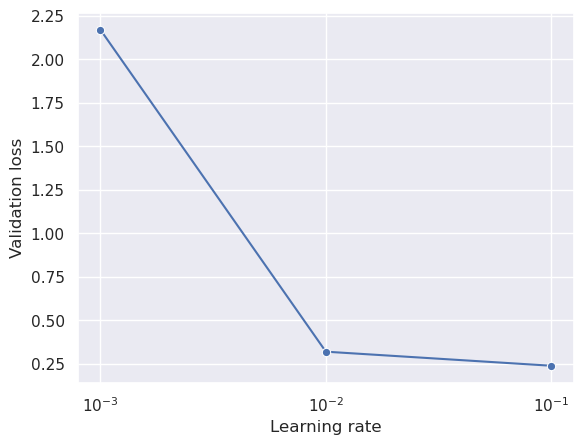

In [68]:
#plot lr vs val_loss_fedavg for fed_fed
sns.set_theme()
sns.set_style("darkgrid")
sns.lineplot(data=df_fed, x='lr', y='val_loss_fedavg',marker='o')
plt.xlabel('Learning rate')
plt.ylabel('Validation loss')
#logscale x-axis
plt.xscale('log')

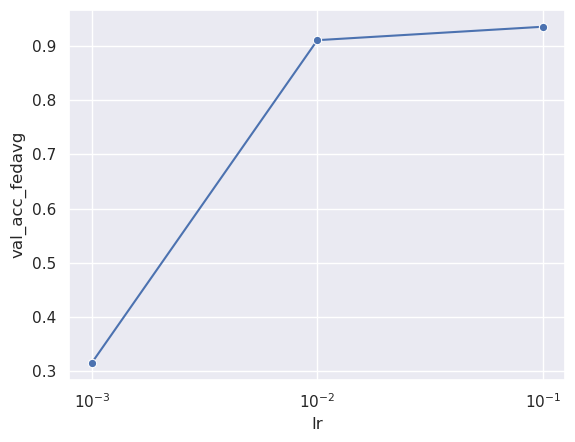

In [69]:
df_fed = df[df['method']=='fedavg']
sns.lineplot(data=df_fed, x='lr', y='val_acc_fedavg',marker='o')
#xlog scale
plt.xscale('log')

<AxesSubplot:xlabel='lr_alpha', ylabel='lr'>

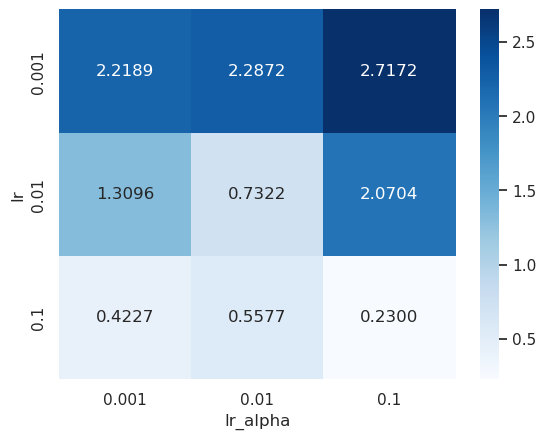

In [75]:
#plot heatmap of val_loss_fedalpha, with lr on x-axis and lr_alpha on y-axis
#drop rows in val_loss_fedalpha with NaN values
df_pivot = df.dropna(subset=['val_loss_fedalpha'])
df_pivot = df_pivot[['lr','lr_alpha','val_loss_fedalpha']].pivot('lr','lr_alpha','val_loss_fedalpha')
sns.heatmap(df_pivot, annot=True, fmt=".4f", cmap="Blues", cbar=True)

<AxesSubplot:xlabel='lr_alpha', ylabel='lr'>

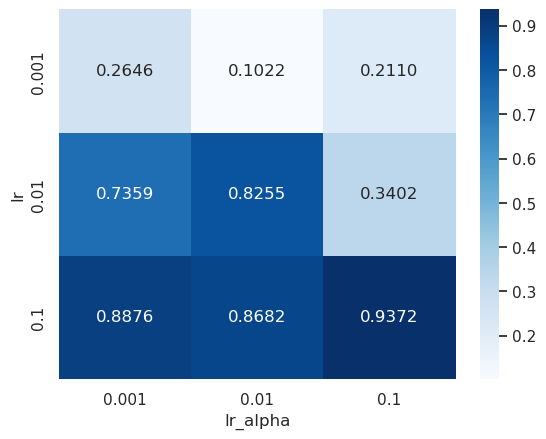

In [76]:
#plot heatmap of val_loss_fedalpha, with lr on x-axis and lr_alpha on y-axis
df_pivot = df.dropna(subset=['val_acc_fedalpha'])
df_pivot = df_pivot[['lr','lr_alpha','val_acc_fedalpha']].pivot('lr','lr_alpha','val_acc_fedalpha')
sns.heatmap(df_pivot, annot=True, fmt=".4f", cmap="Blues", cbar=True)